# **Contents**

[Data joining](#Data-joining)

[Data analysis](#Data-analysis)

[KNN](#KNN)

[Logit](#Logit)

[Naive Bayes](#Naive-Bayes)

[Decision trees](#Decision-trees)

[SVM](#SVM)

[Analyze the best model](#Analyze-the-best-model)

[Predict with new data the best model](#Predict-with-new-data-the-best-model)

In [127]:
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all" 
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.linear_model import LogisticRegression
import seaborn as sns, statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, KFold, ShuffleSplit, \
  StratifiedKFold, GroupShuffleSplit, GroupKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.decomposition import PCA
import collections
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import random
import scipy
import sklearn
random.seed(123)
np.set_printoptions(linewidth=10000, precision=4, edgeitems=20, suppress=True)

Links

In [128]:
link_df = r"link_df = r'main_data.csv'

Logit regression analysis

In [129]:
def feature_importance(model, X_test):
    importance = model.coef_[0]
    #importance is a list so you can plot it. 
    figure = plt.figure()
    feat_importances = pd.Series(importance, index=X_test.columns)
    ax = feat_importances.nlargest(20).plot(kind='barh',title = 'Feature Importance')
    ax.set_xlabel('z-value')
    ax.set_ylabel("variables")

def logit_residuals(df_logreg, threshold):
    #остатки
    sampl_res = np.random.choice(np.where(df_logreg[0] > 0.4, 1-df_logreg[0], 1-df_logreg[1]), 500)
    JB_test = scipy.stats.jarque_bera(sampl_res)
    print('JB stat: ', JB_test.statistic, 'JB pvalue: ', JB_test.pvalue)
    figure = plt.figure()
    sns.histplot(np.where(df_logreg[0] > threshold, 1-df_logreg[0], 1-df_logreg[1]))
    
def logit_plot(model, X_train, y_train):
    figure = plt.figure()
    x_grid = np.linspace(X_train.iloc[:, 0].min(), X_train.iloc[:, 0].max(), X_train.shape[0])
    plt.plot(x_grid, pd.DataFrame(model.predict_proba(X_train))[0].tolist(), color='green', label='Score from logistic regression')
    plt.scatter(x_grid, y_train, c='r');
    plt.legend();
    plt.show()

Functions

In [130]:
#predict  with new data
#def data_convertion_predict(obs, sign, categorical0, link = link_df):

def convertion_predict(sign, X):
    if sign == "log":
        X = np.log(X+1)
    elif sign == "minmax":
        X = (X-X.min())/(X.max()-X.min())
    elif sign == 'z':
        X = (X - X.mean()) / X.std()
    elif sign == "lognorm":
        X = (np.log(X+1) - np.log(X+1).mean()) / np.log(X+1).std()
    elif sign == 'sin':
        X = np.sin(X / len(X))
    return X

In [131]:
def model_summary(ml, X_train, y_train, X_test, y_test):
    sk10 = StratifiedKFold(10)
    cv0 = cross_validate(ml, X_train, y_train, scoring = 'roc_auc',
                     n_jobs = -1, return_train_score=True, cv=sk10)
    score_val = np.mean(cv0["test_score"])
    score_train = np.mean(cv0["train_score"])
    
    y_pred_proba = ml.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba,
                                pos_label = True)
    roc = metrics.auc(fpr, tpr) # area under the ROC for Knn with given k
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba, 
                                                           pos_label = True)
    pr = (metrics.auc(recall, precision))
    
    y_pred_test = ml.predict(X_test)
    balances_acc_test = balanced_accuracy_score(y_test, y_pred_test)
    #print("model summary: ", balances_acc_test)
    return roc, score_val, pr, score_train, balances_acc_test

def conf_m(ml, X_train, y_train, X_test, y_test):
    ml = ml.fit(X_train, y_train)
    y_pr = ml.predict(X_test)
    True_0_class = confusion_matrix(y_test, y_pr, normalize='true')[0][0]
    True_1_class = confusion_matrix(y_test, y_pr, normalize='true')[1][1]
    return sns.heatmap(confusion_matrix(y_test, y_pr, normalize='true'), annot=True), True_0_class, True_1_class

def conf_m_threshold(ml, X_train, y_train, X_test, y_test, threshold=0.5):
    ml = ml.fit(X_train, y_train)
    #y_pr = ml.predict(X_test)
    df_logreg = pd.DataFrame(model.predict_proba(X_test))
    y_pr = np.where(df_logreg[0] > threshold, 0, 1)
    True_0_class = confusion_matrix(y_test, y_pr, normalize='true')[0][0]
    True_1_class = confusion_matrix(y_test, y_pr, normalize='true')[1][1]
    
    return sns.heatmap(confusion_matrix(y_test, y_pr, normalize='true'), annot=True), True_0_class, True_1_class

#main dataset convertion
#def dfYX_convertion(obs, dfYX):

#save results from model training
def save_results(gs_best, sign, gs_cv_res_train, gs_cv_res_val, type_search, balanced_accuracy_test, obs, dfYX, gs_best_params):
    l = []
    link_data_from_models = r'models.csv'
    data = {'model': gs_best, 'params': gs_best_params, 'sign': sign, 'train_roc': np.nanmean(gs_cv_res_train), 'val_roc': np.nanmean(gs_cv_res_val),
        'cols': dfYX.columns, 'obs': obs, 'search': type_search, 'test_accuracy_b': balanced_accuracy_test}
    l.append(data)
    pd.DataFrame.from_dict(l).to_csv(link_data_from_models, mode='a', index=False, header=False)       

def convertion(sign, X_train, X_test):
    if sign == "log":
        X_train = np.log(X_train+1) 
        X_test = np.log(X_test+1)
    elif sign == "minmax":
        X_train = (X_train-X_train.min())/(X_train.max()-X_train.min())
        X_test = (X_test-X_test.min())/(X_test.max()-X_test.min())
    elif sign == 'z':
        X_train = (X_train - X_train.mean()) / X_train.std()
        X_test = (X_test - X_test.mean()) / X_test.std()
    elif sign == "lognorm":
        X_train = (np.log(X_train+1) - np.log(X_train+1).mean()) / np.log(X_train+1).std()
        X_test = (np.log(X_test+1) - np.log(X_test+1).mean()) / np.log(X_test+1).std()
    elif sign == 'sin':
        X_train = np.sin(X_train / len(X_train))
        X_test = np.sin(X_test / len(X_test))
    return X_train, X_test

#data convertion for modelling
#def data_convertion_final(obs, sign, categorical0, link = link_df):

def split(dfYX):
    X_train, X_test, y_train, y_test = tts(dfYX.drop('y', axis=1), dfYX.y, test_size = 0.2, random_state=0, shuffle=True)
    print(f'dimensions of variables: {X_train.shape, X_test.shape, y_train.shape, y_test.shape}')
    collections.Counter(y_train)
    collections.Counter(y_test)
    return X_train, X_test, y_train, y_test
    
def halving_search(model, params, X_train, y_train, X_test, y_test, obs, dfYX):
    sk10 = StratifiedKFold(10)
    gs = HalvingGridSearchCV(model,
                 param_grid = params,
                 verbose = 1,
                 cv = sk10, 
                 scoring = 'roc_auc',
                 n_jobs = -1,
                 return_train_score = True)
    gs_fit = gs.fit(X_train, y_train)
    gs_best = gs_fit.best_estimator_
    gs_best_params = gs_fit.best_params_ 
    gs_cv_res_train = gs.cv_results_["mean_train_score"]
    gs_cv_res_val = gs.cv_results_["mean_test_score"], 
    type_search = 'halving'
    
    roc0, score_val0, pr0, score_train0, balances_acc_test0 = model_summary(gs_best, X_train, y_train, X_test, y_test)
    save_results(gs_best, sign, gs_cv_res_train, gs_cv_res_val, type_search, balances_acc_test0, obs, dfYX, gs_best_params)
    print("done\n")
    
def grid_search(model, params, X_train, y_train, X_test, y_test, obs, dfYX):
    sk10 = StratifiedKFold(10)
    gs = GridSearchCV(model,
         params,
         verbose = 1,
         cv = sk10, 
         scoring = 'roc_auc',
         n_jobs = -1,
         return_train_score = True)
    gs_fit = gs.fit(X_train, y_train)
    gs_best = gs_fit.best_estimator_
    gs_best_params = gs_fit.best_params_ 
    gs_cv_res_train = gs.cv_results_["mean_train_score"]
    gs_cv_res_val = gs.cv_results_["mean_test_score"], 
    type_search = 'grid'
    
    roc0, score_val0, pr0, score_train0, balances_acc_test0 = model_summary(gs_best, X_train, y_train, X_test, y_test)
    save_results(gs_best, sign, gs_cv_res_train, gs_cv_res_val, type_search, balances_acc_test0, obs, dfYX, gs_best_params)
    print("done")
    
def bayes_search(model, params, X_train, y_train, X_test, y_test, obs, dfYX):
    sk10 = StratifiedKFold(10)
    gs = BayesSearchCV(model,
                     params,
                     verbose = 1,
                     cv = sk10, 
                     scoring = 'roc_auc',
                     n_jobs = -1,
                      n_iter = 10,
                      return_train_score = True)
    gs_fit = gs.fit(X_train, y_train)
    gs_best = gs_fit.best_estimator_
    gs_best_params = gs_fit.best_params_ 
    gs_cv_res_train = gs.cv_results_["mean_train_score"]
    gs_cv_res_val = gs.cv_results_["mean_test_score"], 
    type_search = 'bayes'
    
    roc0, score_val0, pr0, score_train0, balances_acc_test0 = model_summary(gs_best, X_train, y_train, X_test, y_test)
    print("123 where", balances_acc_test0)
    save_results(gs_best, sign, gs_cv_res_train, gs_cv_res_val, type_search, balances_acc_test0, obs, dfYX, gs_best_params)
    print("done")
    
def plots(length, roc, acc_test, score_train, score_test):
    sns.set(rc={'figure.figsize':(9.9,5.5)})
    fig, axes = plt.subplots(1, 2)
    k = np.linspace(1, length, num = length, dtype = int)
    sns.lineplot(k, roc, ax = axes[0])
    sns.lineplot(k, acc_test, ax = axes[0])
    sns.lineplot(k, score_train, ax = axes[1])
    sns.lineplot(k, score_test, ax = axes[1])
    #plt.legend(labels = ['ROC-AUC', 'PR', 'CV values', 'train', 'test'])
    axes[0].legend(labels = ['ROC-AUC', 'Balanced_acc'])
    axes[1].legend(labels = ['Train score', 'Test score'])
    #axes[0].set_title('')
    #axes[1].set_title('PCA')
    plt.show()

# Data joining

# Data analysis

In [132]:
['all', 'no active', 'active']#type of users

dfYX = pd.read_csv(link_df, index_col=0)
#dfYX.info()

obs = 'all' #leave all users in dataset
dfYX = dfYX_convertion(obs, dfYX)
#dfYX.info()

#dependent variable we are interested
print('\ny distribution: ', dfYX.y.value_counts())
dfYX_equal_sample = pd.concat([dfYX[dfYX.y == 0].sample(n=dfYX[dfYX.y == 1].shape[0]), 
                               dfYX[dfYX.y == 1]])
#describe_f(dfYX_equal_sample)
print('y distribution ', dfYX_equal_sample.y.value_counts())

dfYX_equal_sample.columns = ['01', '02', '03', '04', '05', '06', '07',
       'y', '09', '10','11', '12', '13', '14', '15', '16','17', '18']
dfYX.columns = ['01', '02', '03', '04', '05', '06', '07',
       'y', '09', '10','11', '12', '13', '14', '15', '16','17', '18']
dfYX.info()

['all', 'no active', 'active']


y distribution:  0    16764
1      721
Name: y, dtype: int64
y distribution  0    721
1    721
Name: y, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17485 entries, 203472 to 232427
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   01      17485 non-null  float64
 1   02      17485 non-null  float64
 2   03      17485 non-null  float64
 3   04      17485 non-null  int64  
 4   05      17485 non-null  float64
 5   06      17485 non-null  int64  
 6   07      17485 non-null  float64
 7   y       17485 non-null  int64  
 8   09      17485 non-null  float64
 9   10      17485 non-null  float64
 10  11      17485 non-null  float64
 11  12      17485 non-null  float64
 12  13      17485 non-null  int64  
 13  14      17485 non-null  float64
 14  15      17485 non-null  int64  
 15  16      17485 non-null  float64
 16  17      17485 non-null  float64
 17  18      17485 non-null  int64  
dtypes: float64(12), int64(

Distributions

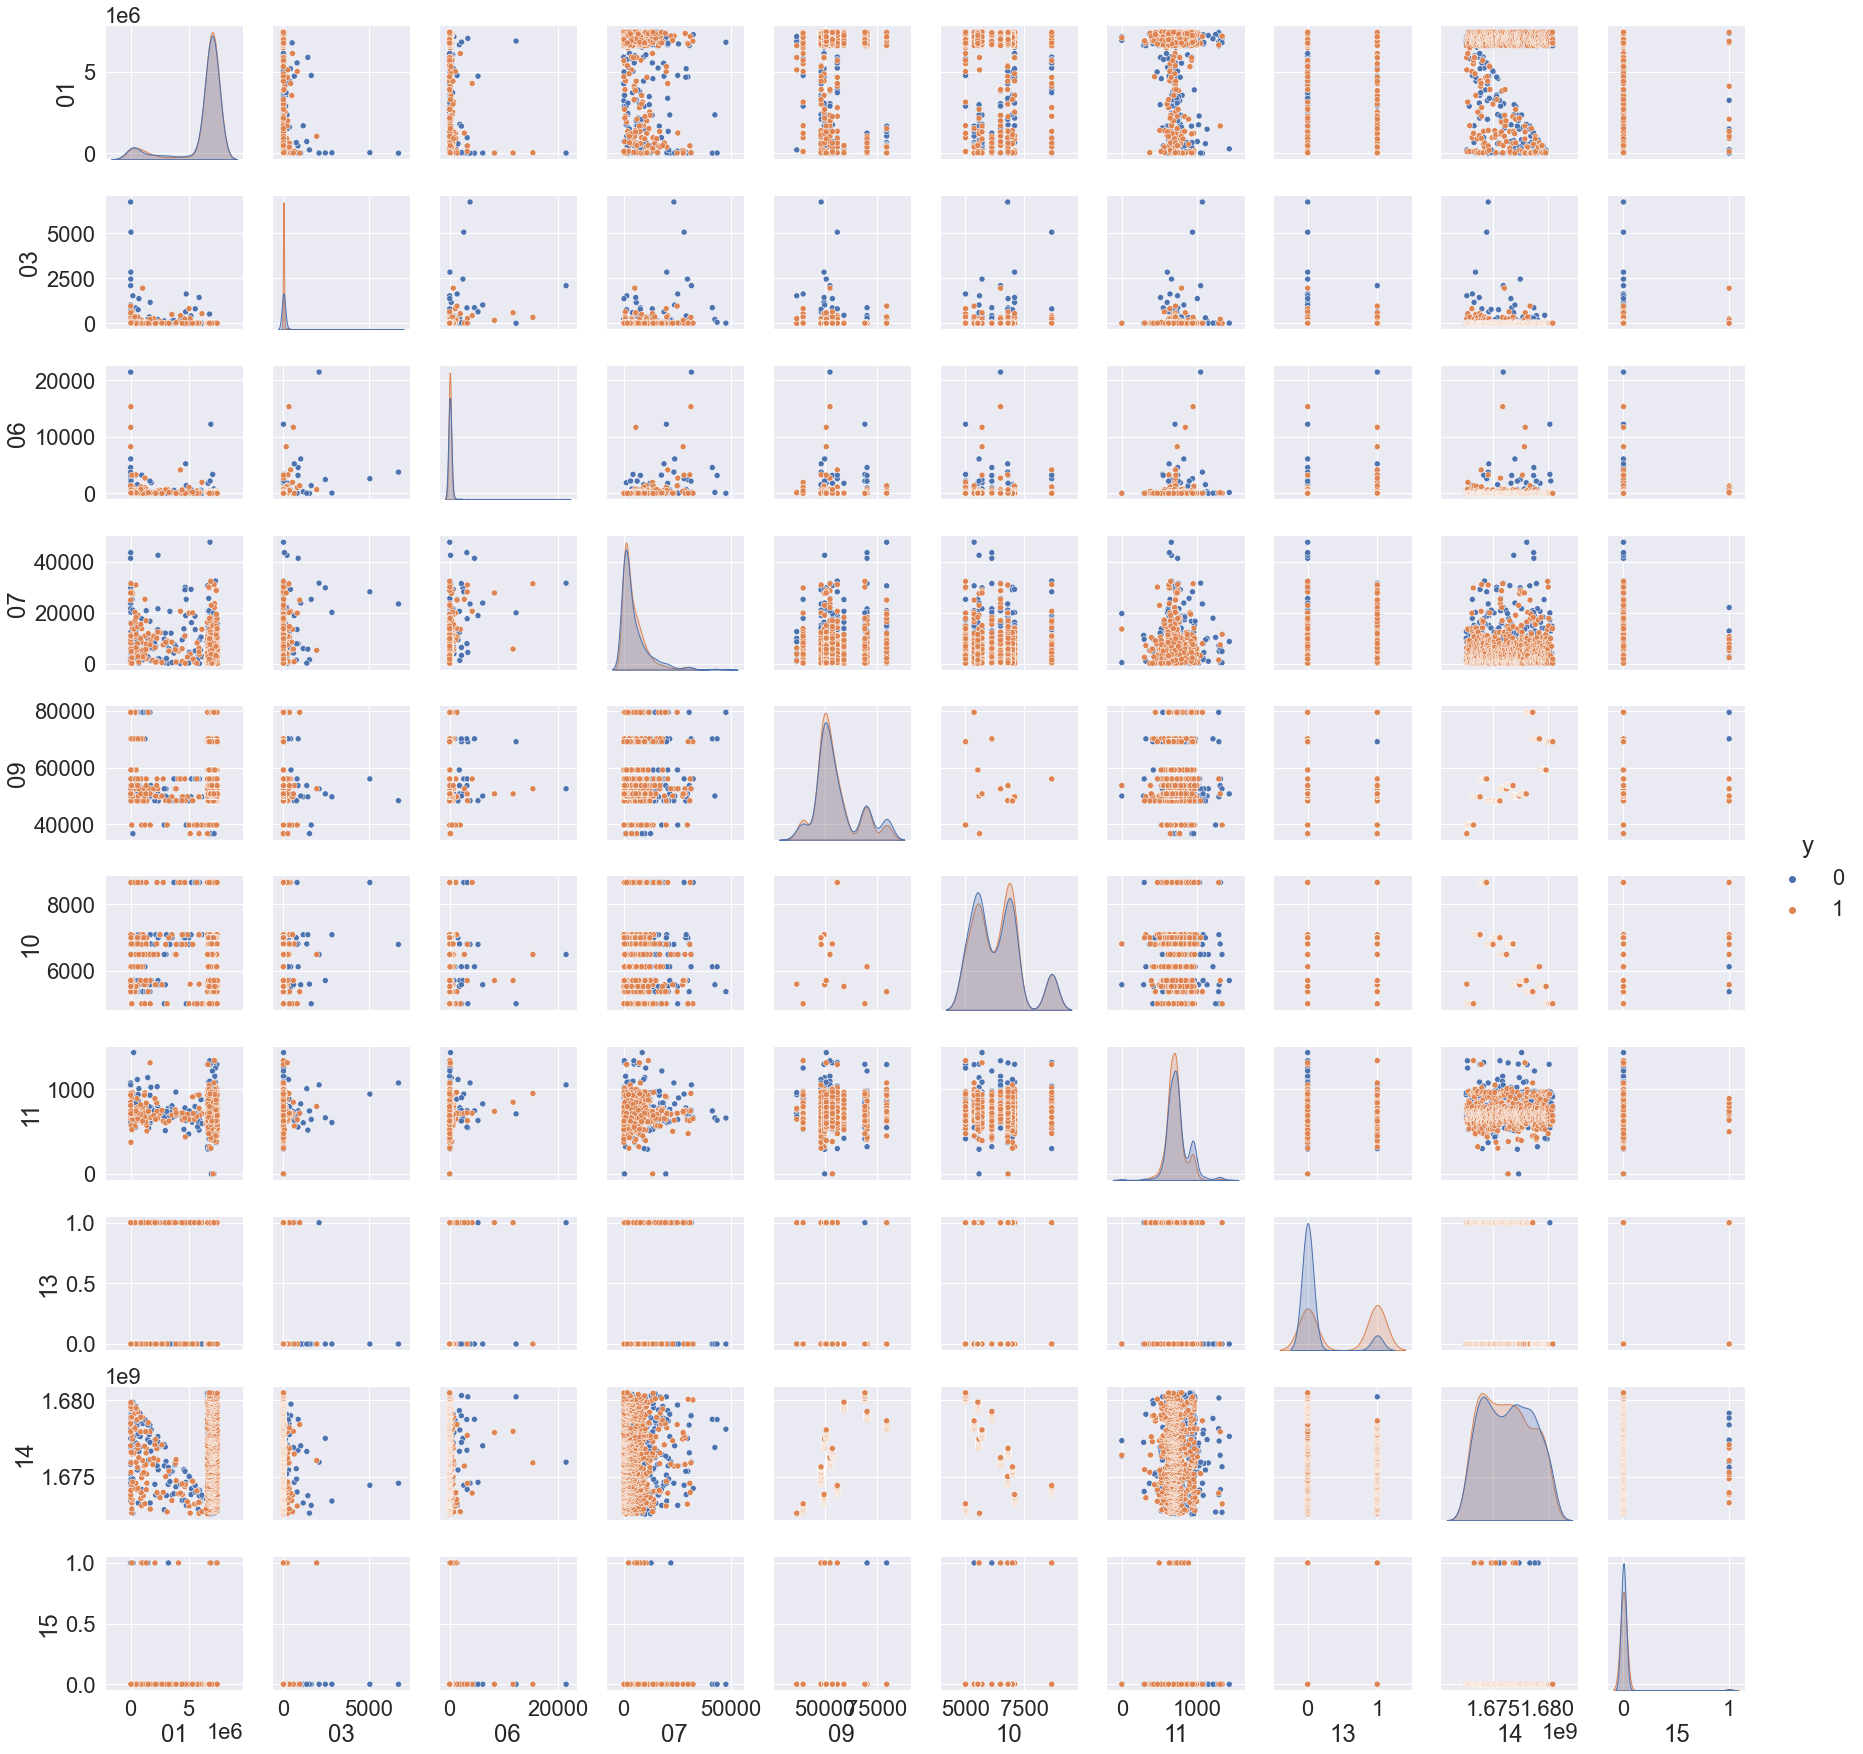

In [133]:
sns.set(font_scale = 2)
g1 = sns.pairplot(dfYX_equal_sample.drop(errors = 'ignore', columns={"02", "04", "16", "17", "18", "05", '12'}), 
             diag_kind='kde', hue="y")
plt.show()

Heatmap

<Figure size 1008x576 with 0 Axes>

<AxesSubplot:>

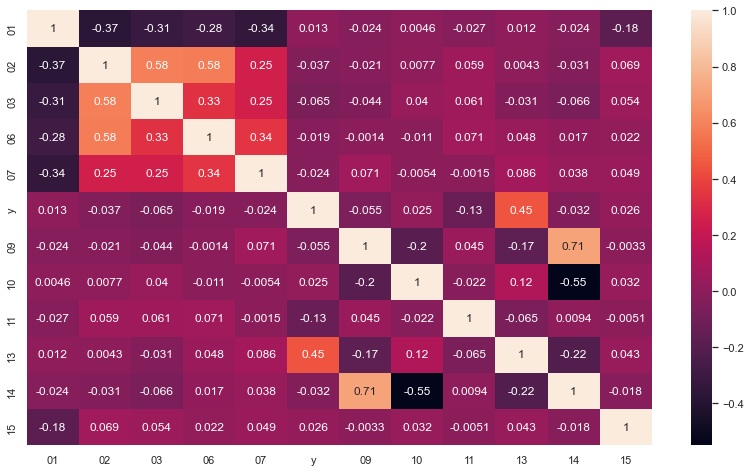

In [134]:
plt.figure(figsize=(14, 8))
sns.set(rc={'figure.figsize':(9.9,5.5)})
sns.set_style("darkgrid")
sns.heatmap(dfYX_equal_sample.drop(errors = 'ignore', 
            columns={"04", "16", "17", "18", "05", '12'}).corr(), annot=True)

<Figure size 1008x576 with 0 Axes>

<AxesSubplot:xlabel='y', ylabel='17'>

<AxesSubplot:xlabel='y', ylabel='03'>

<AxesSubplot:xlabel='y', ylabel='16'>

<AxesSubplot:xlabel='y', ylabel='05'>

<Figure size 1008x576 with 0 Axes>

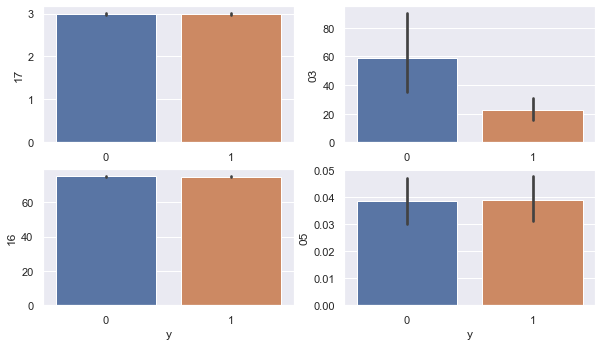

In [135]:
plt.figure(figsize=(14, 8))
fig, ax = plt.subplots(2, 2)

sns.barplot(x=dfYX_equal_sample['y'], y=dfYX_equal_sample['17'], ax=ax[0][0])
sns.barplot(x=dfYX_equal_sample['y'], y=dfYX_equal_sample['03'], ax=ax[0][1]) 
sns.barplot(x=dfYX_equal_sample['y'], y=dfYX_equal_sample['16'], ax=ax[1][0])
sns.barplot(x=dfYX_equal_sample['y'], y=dfYX_equal_sample['05'], ax=ax[1][1])

<Figure size 1008x576 with 0 Axes>

<Figure size 1008x576 with 0 Axes>

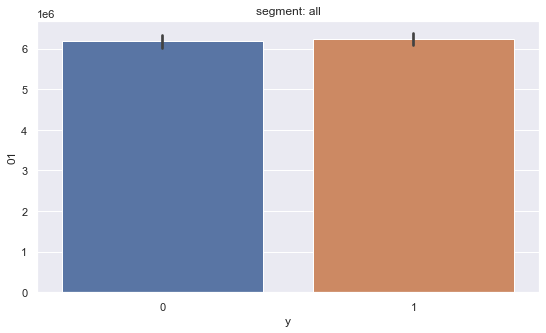

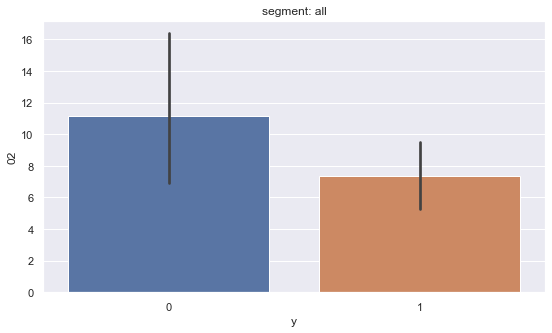

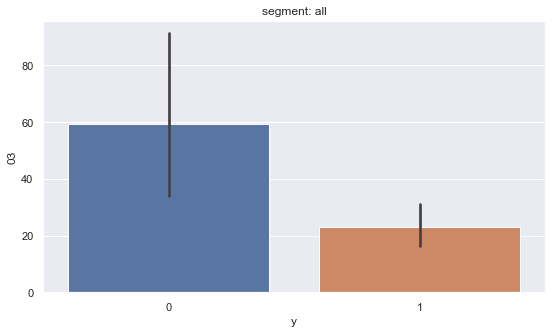

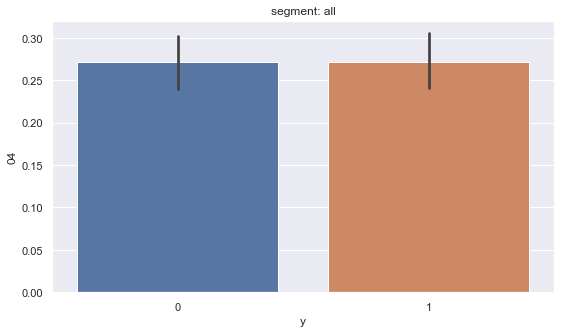

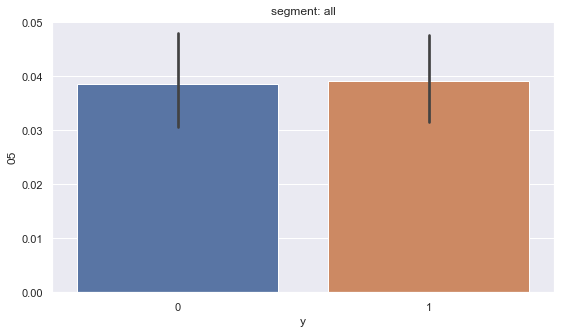

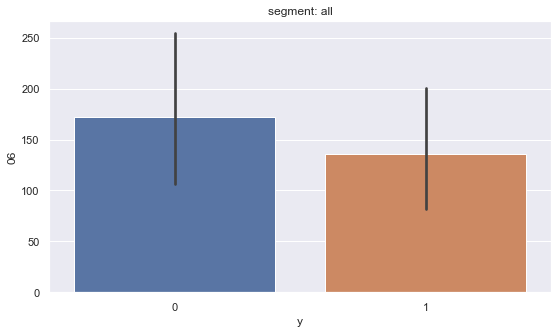

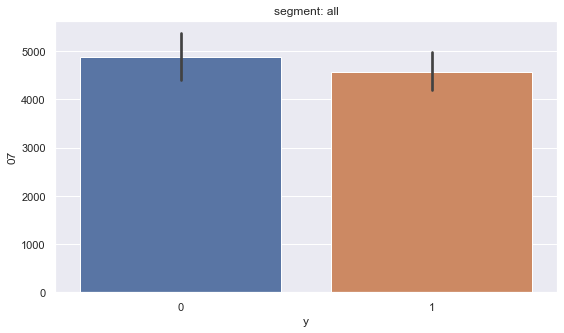

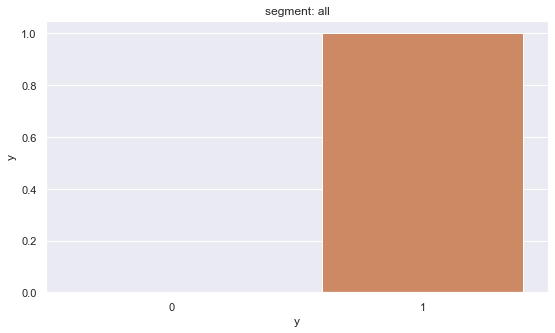

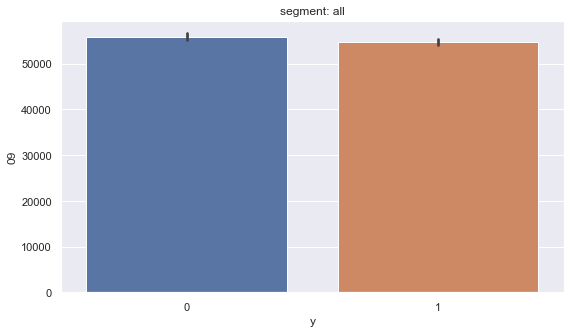

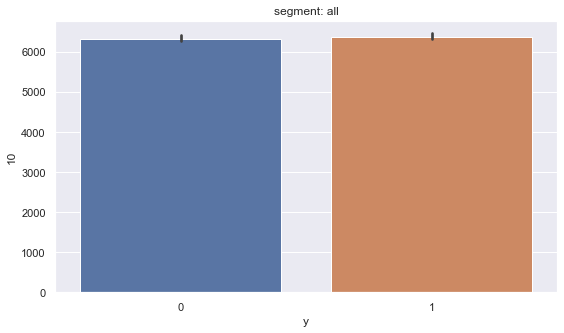

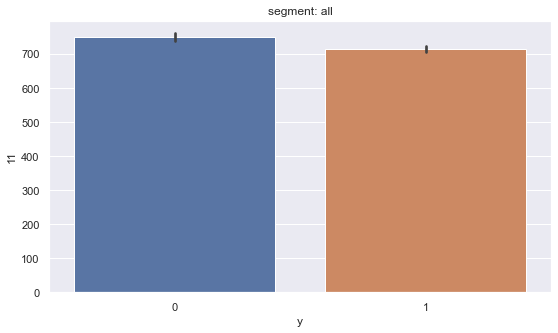

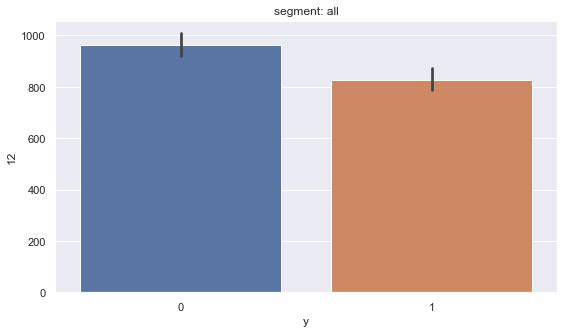

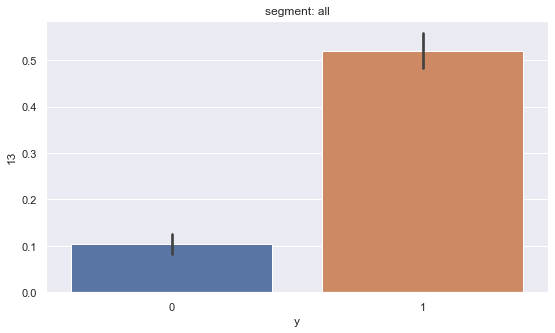

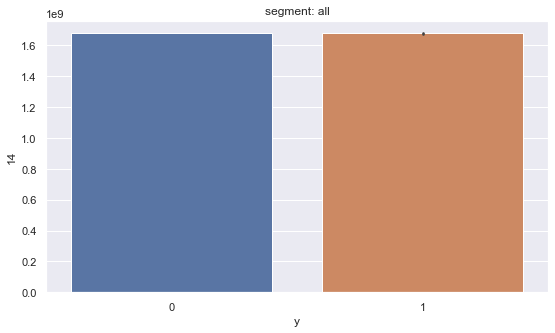

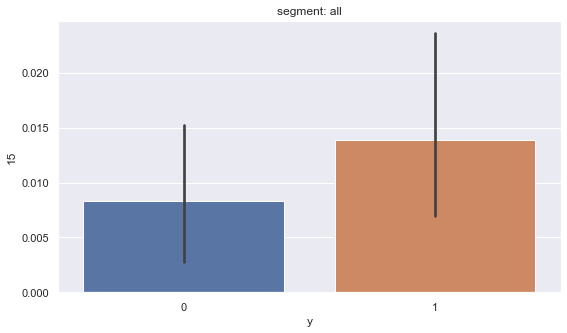

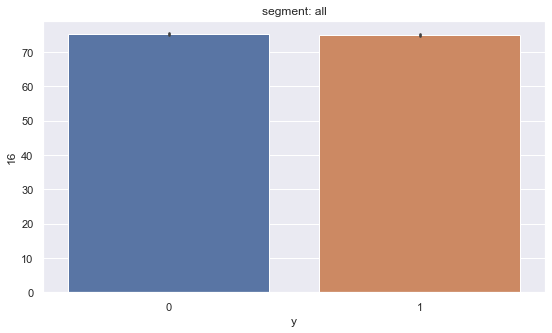

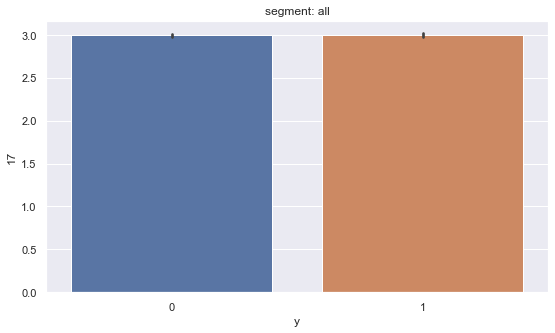

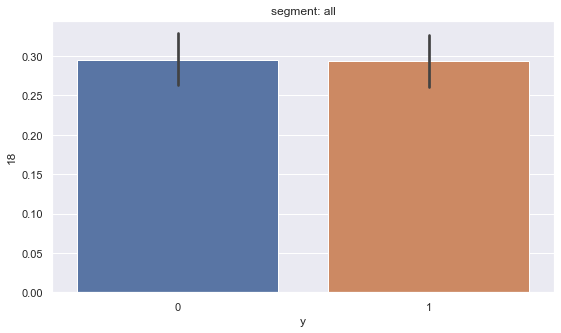

In [136]:
plt.figure(figsize=(14, 8))
sns.set(rc={'figure.figsize':(9,5)})
sns.set_style("darkgrid")

for colname in dfYX_equal_sample.columns:
    figure = plt.figure()
    ax = sns.barplot(x=dfYX_equal_sample['y'], y=dfYX_equal_sample[colname]).set_title(f"segment: {obs}")

Models

[KNN](#KNN)

[Logit](#Logit)

[Decision trees](#Decision-trees)

[SVM](#SVM)

Create file for data from models

In [137]:
r'''pd.DataFrame({'model': [], 'params': [], 'sign': [], 'train_roc': [], 'val_roc': [],
    'cols': [], 'obs': [], 'search': [], 'test_accuracy_b': []}).to_csv("models.csv", index=False)'''

'pd.DataFrame({\'model\': [], \'params\': [], \'sign\': [], \'train_roc\': [], \'val_roc\': [],\n    \'cols\': [], \'obs\': [], \'search\': [], \'test_accuracy_b\': []}).to_csv("models.csv", index=False)'

# **KNN**

# **Logit**

Трансформация

In [138]:
['all', 'no active', 'active']
["z", "log", "minmax", "lognorm", "sin"] #transformation
['include', 'drop'] #include or drop these columns

obs = 'all'
sign = 'z'
categorical0 = 'include'

X_train, X_test, dfYX, y_train, y_test = data_convertion_final(obs, sign, categorical0, link = link_df)

X_train.columns = ['01', '02', '03', '04', '05', '06', '07', '08',
       '09', '10','11', '12', '13', '14', '15', '16','17']
X_test.columns = ['01', '02', '03', '04', '05', '06', '07', '08',
       '09', '10','11', '12', '13', '14', '15', '16','17']
#display(dfYX)
X_test.info()
#describe_f(X_train)

['all', 'no active', 'active']

['z', 'log', 'minmax', 'lognorm', 'sin']

['include', 'drop']

dimensions of variables: ((13988, 17), (3497, 17), (13988,), (3497,))
X_train shape:  13988 X_test shape:  3497 y_train shape:  13988 y_test shape:  3497
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3497 entries, 220692 to 229688
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   01      3497 non-null   float64
 1   02      3497 non-null   float64
 2   03      3497 non-null   float64
 3   04      3497 non-null   float64
 4   05      3497 non-null   float64
 5   06      3497 non-null   float64
 6   07      3497 non-null   float64
 7   08      3497 non-null   float64
 8   09      3497 non-null   float64
 9   10      3497 non-null   float64
 10  11      3497 non-null   float64
 11  12      3497 non-null   float64
 12  13      3497 non-null   float64
 13  14      3497 non-null   int64  
 14  15      3497 non-null   int64  
 15  16      3497 non-null   int64  
 16  17      3497 non-null   int64  
dtypes: float64(13), int64(4)

example search

Optimization terminated successfully.
         Current function value: 0.152674
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                13988
Model:                          Logit   Df Residuals:                    13970
Method:                           MLE   Df Model:                           17
Date:                Thu, 18 May 2023   Pseudo R-squ.:                  0.1322
Time:                        19:41:22   Log-Likelihood:                -2135.6
converged:                       True   LL-Null:                       -2460.8
Covariance Type:            nonrobust   LLR p-value:                2.928e-127
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8333      0.080    -47.665      0.000      -3.991      -3.676
01            -0.0519      0

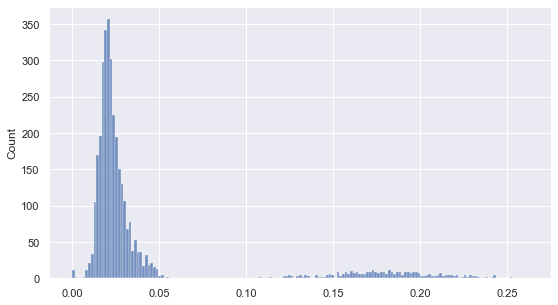

In [139]:
import statsmodels.api as sm
mdl = sm.Logit(y_train, sm.add_constant(X_train))
# Fit our model on training data
fmdl = mdl.fit()
print(fmdl.summary())

model = LogisticRegression().fit(X_train, y_train)
df_logreg = pd.DataFrame(model.predict_proba(X_test))
#check logit residuals on normality
logit_residuals(df_logreg, threshold=0.4)

In [39]:
grid_p = {"C": np.logspace(-5,5,10), 
         'fit_intercept': [True, False],   
         'solver': ['liblinear', 
                   'lbfgs'],
          'l1_ratio': [0, 0.5, 1, 2, 5, None]}
model = LogisticRegression()

halving_search(model, grid_p, X_train, y_train, X_test, y_test, obs, dfYX)
bayes_search(model, grid_p, X_train, y_train, X_test, y_test, obs, dfYX)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 172
max_resources_: 13988
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 240
n_resources: 172
Fitting 10 folds for each of 240 candidates, totalling 2400 fits


C:\Users\PC\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan

----------
iter: 1
n_candidates: 80
n_resources: 516
Fitting 10 folds for each of 80 candidates, totalling 800 fits


C:\Users\PC\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan

----------
iter: 2
n_candidates: 27
n_resources: 1548
Fitting 10 folds for each of 27 candidates, totalling 270 fits


C:\Users\PC\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [   nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    na

----------
iter: 3
n_candidates: 9
n_resources: 4644
Fitting 10 folds for each of 9 candidates, totalling 90 fits


C:\Users\PC\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [   nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    na

----------
iter: 4
n_candidates: 3
n_resources: 13932
Fitting 10 folds for each of 3 candidates, totalling 30 fits


C:\Users\PC\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [   nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan    na

model summary:  0.5
done

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\Users\PC\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


model summary:  0.5
123 where 0.5
done


In [53]:
grid_p = {"C": np.logspace(-5,5,10), 
          "penalty": ["l1","l2", 'elasticnet', 'none'],
         'fit_intercept': [True, False],   
         'solver': ['liblinear', 
                   'lbfgs', 'sag', 'saga'],
          'l1_ratio': [0, 0.5, 1, 2, 5, None],
         'class_weight': [dict(y_train.value_counts() / len(y_train)), 'balanced']}
model = LogisticRegression()

grid_search(model, grid_p, X_train, y_train, X_test, y_test, obs, dfYX)

'grid_p = {"C": np.logspace(-5,5,10), \n          "penalty": ["l1","l2", \'elasticnet\', \'none\'],\n         \'fit_intercept\': [True, False],   \n         \'solver\': [\'liblinear\', \n                   \'lbfgs\', \'sag\', \'saga\'],\n          \'l1_ratio\': [0, 0.5, 1, 2, 5, None],\n         \'class_weight\': [dict(y_train.value_counts() / len(y_train)), \'balanced\']}\nmodel = LogisticRegression()\n\ngrid_search(model, grid_p, X_train, y_train, X_test, y_test, obs, dfYX)'

# Decision trees

# Naive Bayes

# Bagging

# SVM

# Analyze the best model

In [140]:
models_results = pd.read_csv(r"C:\Users\PC\Desktop\job\Documents GRX\Segmentation GRX\ML\models.csv") \
.drop(columns={'cols'})
models_results.sort_values('val_roc', ascending=False).iloc[:15, :]

for ii in models_results.columns:
    print(f'{ii}:', models_results[models_results.index == 65][ii].tolist()[0], '\n--------------------------------------------')

,model,params,sign,train_roc,val_roc,obs,search,test_accuracy_b
73,LogisticRegression(),LogisticRegression(),z,0.815019,0.811343,no active,Na,0.500000
53,LogisticRegression(),LogisticRegression(),z,0.804908,0.802710,all,Na,0.499948
80,LogisticRegression(),LogisticRegression(),z,0.804350,0.802159,all,Na,0.500000
97,LogisticRegression(),LogisticRegression(),z,0.803881,0.800131,no active,Na,0.500000
87,LogisticRegression(),LogisticRegression(),z,0.790008,0.787618,all,Na,0.499948
89,LogisticRegression(),LogisticRegression(),z,0.790008,0.787618,all,Na,0.499948
65,"LogisticRegression(C=0.021544346900318846, cla...","LogisticRegression(C = 0.021544346900318846,\...",z,0.790161,0.786248,no active,Na,0.676176
74,"LogisticRegression(C=0.021544346900318846, cla...","LogisticRegression(C = 0.021544346900318846,\...",z,0.789558,0.785632,no active,Na,0.677522
57,GaussianNB(var_smoothing=0.01),{'var_smoothing': 0.01},z,0.789578,0.785488,no active,grid,0.744127
59,GaussianNB(var_smoothing=0.01),"OrderedDict([('var_smoothing', 0.01)])",z,0.789302,0.784972,no active,bayes,0.744127


model: LogisticRegression(C=0.021544346900318846, class_weight='balanced',
                   fit_intercept=False, solver='liblinear') 
--------------------------------------------
params:  LogisticRegression(C = 0.021544346900318846,
 class_weight = 'balanced',
 fit_intercept = False, penalty =  'l2',
 solver = 'liblinear') 
--------------------------------------------
sign: z 
--------------------------------------------
train_roc: 0.7901609484861669 
--------------------------------------------
val_roc: 0.7862480283156256 
--------------------------------------------
obs: no active 
--------------------------------------------
search: Na 
--------------------------------------------
test_accuracy_b: 0.6761761128954985 
--------------------------------------------


In [141]:
['all', 'no active', 'active']
["z", "log", "minmax", "lognorm", "sin"]
['include', 'drop']

obs = 'all'
sign = 'z'
categorical0 = 'include'

X_train, X_test, dfYX, y_train, y_test = data_convertion_final(obs, sign, categorical0, link = link_df)
    
#display(dfYX)
#describe_f(X_test)
#describe_f(X_train)

['all', 'no active', 'active']

['z', 'log', 'minmax', 'lognorm', 'sin']

['include', 'drop']

dimensions of variables: ((13988, 17), (3497, 17), (13988,), (3497,))
X_train shape:  13988 X_test shape:  3497 y_train shape:  13988 y_test shape:  3497


In [142]:
#The best model
model = LogisticRegression(C = 0.021544346900318846, class_weight = 'balanced',
fit_intercept = False, penalty =  'l2', solver = 'liblinear') 

model = model.fit(X_train, y_train)
df_logreg = pd.DataFrame(model.predict_proba(X_test))

model.classes_

array([0, 1], dtype=int64)

Accuracy

In [143]:
accuracies = []
threshold0 = []
for j in np.linspace(0, 1, 21):
    arr_pred = np.where(df_logreg[0] > j, 0, 1)
    accuracies.append(balanced_accuracy_score(y_test, arr_pred))
    threshold0.append(j)
    print("j = ", j, '%', balanced_accuracy_score(y_test, arr_pred), 'total accuracy:', accuracy_score(y_test, arr_pred), '\n')
print(f"Max balanced accuracy score for threshold {threshold0[accuracies.index(max(accuracies))]} is %.3f" % max(accuracies))

j =  0.0 % 0.5 total accuracy: 0.9639691163854732 

j =  0.05 % 0.5 total accuracy: 0.9639691163854732 

j =  0.1 % 0.4994067042420647 total accuracy: 0.9628252788104089 

j =  0.15000000000000002 % 0.5618993469037966 total accuracy: 0.9433800400343151 

j =  0.2 % 0.6506500355506585 total accuracy: 0.9156419788390049 

j =  0.25 % 0.6946363238264751 total accuracy: 0.8973405776379754 

j =  0.30000000000000004 % 0.708247988209424 total accuracy: 0.8867600800686303 

j =  0.35000000000000003 % 0.7159996798086385 total accuracy: 0.8796110952244781 

j =  0.4 % 0.7332099654852546 total accuracy: 0.8538747497855305 

j =  0.45 % 0.7289132799367151 total accuracy: 0.7866742922505005 

j =  0.5 % 0.715053231813837 total accuracy: 0.6568487274806978 

j =  0.55 % 0.6647031402296901 total accuracy: 0.48613096940234485 

j =  0.6000000000000001 % 0.6180611471326393 total accuracy: 0.32256219616814413 

j =  0.65 % 0.554284207502837 total accuracy: 0.1701458392908207 

j =  0.7000000000000001 %

Check bias-varriance tradeoff

C:\Users\PC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\PC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\PC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\PC\anaconda3\lib\site-

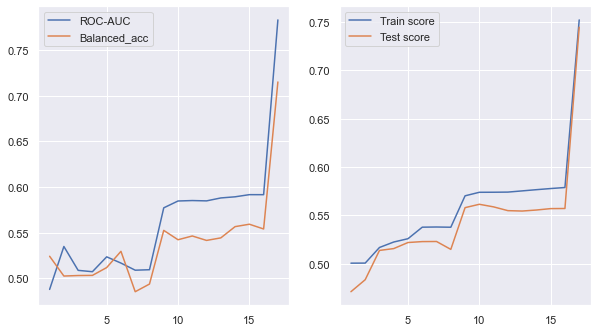

In [145]:
roc = []
score_train = []
score_test = []
pr = []
acc_test = []
logreg = model

for i in range(1, X_train.shape[1]+1):
    logreg = logreg.fit(X_train.iloc[:, :i], y_train)
    roc0, score_val0, pr0, score_train0, balances_acc_test0 = model_summary(logreg, X_train.iloc[:, :i], 
                                                    y_train, X_test.iloc[:, :i], y_test)
    roc.append(roc0)
    score_train.append(score_train0)
    score_test.append(score_val0)
    pr.append(pr0)
    acc_test.append(balances_acc_test0)
    #print("====")
    
plots(len(roc), roc, acc_test, score_train, score_test)

Confusion matrix, feature importance, normality assumption

(<AxesSubplot:>, 0.7911598932067636, 0.6666666666666666)

JB stat:  27.30050651811525 JB pvalue:  1.179696614284076e-06


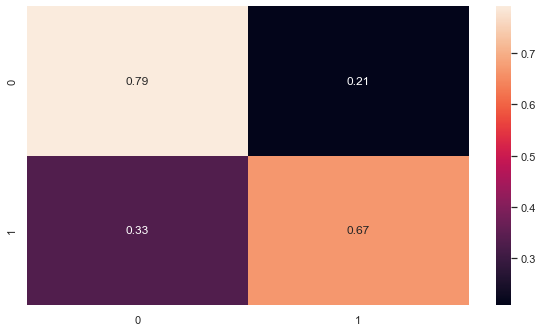

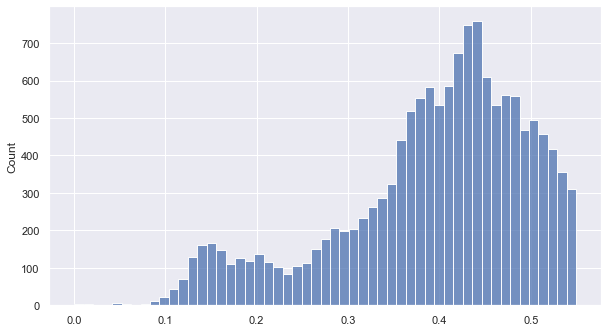

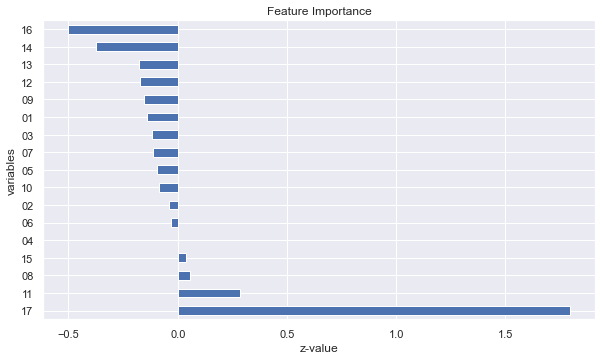

In [146]:
df_logreg = pd.DataFrame(model.predict_proba(X_train))
#threshold_model = 0.45 is choosen
threshold_model = 0.45

conf_m_threshold(model, X_train, y_train, X_test, y_test, threshold=threshold_model)
logit_residuals(df_logreg, threshold=threshold_model)

X_test.columns = ['01', '02', '03', '04', '05', '06', '07', '08',
       '09', '10','11', '12', '13', '14', '15', '16','17']
feature_importance(model, X_test)

# Predict with the best model using new data